In [125]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from to_plot import plot_ball_timeseries

## Load all the files 

In [127]:
import glob
import json
import pandas as pd
import numpy as np
from tqdm import tqdm

# 1. Define your folder path (Change 'data_folder' to your actual path)
folder_path = "data/*.json" 
file_list = glob.glob(folder_path)

frames_list = []
m = 15  # Window size (needed for the spacer)

print(f"Found {len(file_list)} files. Starting concatenation...")

# 2. Loop through every file in the folder
for filepath in tqdm(file_list):
    # B. Convert to DataFrame
    df_temp = pd.read_json(filepath)
    df_temp = df_temp.T  # Transpose if necessary
    df_temp=df_temp[df_temp['visible']==1]
    df_temp=df_temp.drop(columns=['visible'])
    
    df_temp['filename'] = filepath
    
    # E. Add to list
    frames_list.append(df_temp)
    
    # F. Insert "Spacer" (NaNs) between files
    # This prevents the algorithm from analyzing a pattern that crosses two different matches
    # spacer = pd.DataFrame(index=range(m), columns=df_temp.columns)
    # spacer['y'] = np.nan       # Stumpy ignores windows with NaNs
    # spacer['filename'] = 'SPACER'
    # frames_list.append(spacer)

# 3. Concatenate all files into one distinct DataFrame
full_df = pd.concat(frames_list)

print(f"Successfully created 'full_df' with shape: {full_df.shape}")

Found 313 files. Starting concatenation...


100%|██████████| 313/313 [00:23<00:00, 13.18it/s]

Successfully created 'full_df' with shape: (113673, 4)


In [128]:
full_df

,x,y,action,filename
324564,849,257,air,data/ball_data_115.json
324565,850,251,air,data/ball_data_115.json
324566,849,243,air,data/ball_data_115.json
324567,850,236,air,data/ball_data_115.json
324568,851,230,air,data/ball_data_115.json
...,...,...,...,...
655760,1024,401,air,data/ball_data_246.json
655761,1023,398,air,data/ball_data_246.json
655762,1023,396,air,data/ball_data_246.json
655763,1021,393,air,data/ball_data_246.json


In [3]:
# test_df=full_df[full_df['filename']=='data/ball_data_115.json'].copy()
test_df=df.copy()

In [129]:
def cosine_similarity(a_x, a_y, b_x, b_y):
    """Compute the cosine similarity between two vectors."""
    a = np.array([a_x, a_y])
    b = np.array([b_x, b_y])
    return np.dot(a, b) # / (np.linalg.norm(a) * np.linalg.norm(b))

In [130]:
import numpy as np

def safe_cosine_similarity(v1, v2, threshold=1e-5):
    # 1. Calculate Dot Product
    dot_product = np.dot(v1, v2)
    
    # 2. Calculate Magnitudes (Lengths)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    
    # 3. SAFETY CHECK: Are we moving fast enough?
    # If either vector is too short (ball stopped or jittering), return 1.0 (assume no direction change)
    if norm_v1 < threshold or norm_v2 < threshold:
        return 1.0 
        
    # 4. Calculate Cosine Similarity
    similarity = dot_product / (norm_v1 * norm_v2)
    
    # 5. Clip result to [-1, 1] to handle floating point errors
    # (Sometimes python math results in 1.000000002 which breaks arccos)
    return np.clip(similarity, -1.0, 1.0)

In [131]:
window_size = 7
vx_before=full_df['x']-full_df['x'].shift(window_size)
vy_before=full_df['y']-full_df['y'].shift(window_size)
vx_after=full_df['x']-full_df['x'].shift(-window_size)
vy_after=full_df['y']-full_df['y'].shift(-window_size)



In [132]:
vx_before = vx_before.fillna(method='bfill')
vy_before = vy_before.fillna(method='bfill')
vx_after = vx_after.fillna(method='bfill')
vy_after = vy_after.fillna(method='bfill')

/tmp/ipykernel_28570/1647225368.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vx_before = vx_before.fillna(method='bfill')
/tmp/ipykernel_28570/1647225368.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vx_before = vx_before.fillna(method='bfill')
/tmp/ipykernel_28570/1647225368.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vy_before = vy_before.fillna(method='bfill')
/tmp/ipykernel_28570/1647225368.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To op

In [84]:
vx_before

324564      2.0
324565      2.0
324566      2.0
324567      2.0
324568      2.0
          ...  
325189    -61.0
325190    -61.0
325196   -108.0
325197   -106.0
325198   -104.0
Name: x, Length: 572, dtype: float64

In [133]:
import numpy as np

def cosine_similarity_rows(A, B, threshold=1e-3):
    # A and B should be shape (500, 2)
    
    # 1. Dot product row-by-row
    # We multiply element-wise, then sum ACROSS columns (axis=1) to get one number per row
    dot_products = np.sum(A * B, axis=1)
    
    # 2. Magnitudes (Norms) per row
    norm_A = np.linalg.norm(A, axis=1)
    norm_B = np.linalg.norm(B, axis=1)
    
    # 3. Handle small speeds (avoid division by zero)
    # Create a mask of rows where vectors are long enough
    valid_mask = (norm_A > threshold) & (norm_B > threshold)
    
    # Initialize result array of zeros (or 1s) with shape (500,)
    similarities = np.ones(A.shape[0])
    
    # 4. Calculate only on valid rows
    similarities[valid_mask] = dot_products[valid_mask] / (norm_A[valid_mask] * norm_B[valid_mask])
    delta_speed=norm_A-norm_B
    # 5. Clip to handle floating point errors
    return np.clip(similarities, -1.0, 1.0),delta_speed

# --- EXAMPLE USAGE ---

# Let's say your vectors are arranged like this (500 rows, 2 cols)
vecs_before = np.random.rand(500, 2) 
vecs_after = np.random.rand(500, 2)

# Run the function
scores,delta_speed = cosine_similarity_rows(vecs_before, vecs_after)

print(scores.shape) 
# Output: (500,)

(500,)


In [134]:
full_df['cosine_sim'],full_df['delta_speed']=cosine_similarity_rows(np.array([vx_before, vy_before]).T, np.array([vx_after, vy_after]).T, threshold=1e-3)

In [146]:
full_df['delta_speed']=full_df['delta_speed'].ffill()

In [122]:
import numpy as np
import pandas as pd


# 2. Convert Cosine Scores to Angles (in Degrees)
# arccos takes the cosine and gives back radians. We convert to degrees.
# We clip to (-1, 1) just to be super safe against floating point errors.

# 3. Calculate Rolling Standard Deviation (Centered)
# We convert to a Pandas Series to use the powerful rolling function
window_size = 5  # Look at 2 frames before and 2 frames after

rolling_std = test_df['cosine_sim'].rolling(window=window_size, center=True).mean()
rolling_std=test_df['cosine_sim']/rolling_std

# Convert back to NumPy array if needed
std_values = rolling_std.to_numpy()

# --- INTERPRETATION ---
# NaN values will appear at the very start and end (edges of the window)
# We can fill them with 0 or the nearest valid value
std_values = np.nan_to_num(std_values, nan=0.0)
std_values=np.clip(std_values,-10,10)

# Check results
print("First 10 rolling STD values:", std_values)

First 10 rolling STD values: [  0.           0.           1.00019646   0.99743184   1.01331632
   1.21527484   1.6209553    0.69255861   6.94570648   1.38037237
   1.05965347   1.12434967   1.81490937   3.62371634   2.10243702
   1.52387211   1.14053761   1.02760497   1.01164313   1.00805883
   0.99754628   1.00410285   1.00201163   0.99952669   1.00185907
   1.0051069    1.01435013   1.02262708   1.03393488   0.99412397
   0.87803164   0.97893486   1.0188238    0.99662216   1.00776307
   1.02537611   1.01852055   0.98338792   1.08603157   1.46829794
   1.68657874  -8.91977125   1.63391032   1.19042296   1.15494144
   1.35067563   2.3139759    0.73535575   1.84640375   1.24327865
   1.04749547   1.01227095   1.00201395   1.00133029   0.99924943
   0.99743563   1.00180409   1.00065062   1.00052763   0.99987157
   0.99714301   1.00314639   1.0027198    0.99575795   0.99997796
   1.00294666   0.9961685    0.99765809   1.00988079   1.00840329
   0.9915601    1.00764987   0.98582228   1.013

In [123]:
test_df['delta_speed_avg_ratio']=std_values


## kmeans to test 

In [147]:
full_df.isna().sum()

x              0
y              0
action         0
filename       0
cosine_sim     0
delta_speed    0
dtype: int64

In [150]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns

df_model=full_df.drop(columns=['action','filename'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model)

# Fit K-Means
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
full_df['cluster'] = kmeans.fit_predict(X_scaled)


In [151]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create the contingency table
# Rows = Actual Actions (Ground Truth)
# Columns = Predicted Clusters (0, 1, 2)
crosstab = pd.crosstab(full_df['action'], full_df['cluster'])

print("--- Confusion Matrix (Counts) ---")
print(crosstab)

--- Confusion Matrix (Counts) ---
cluster      0      1
action               
air      19439  91188
bounce     399   1047
hit       1404    196


In [155]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# --- STEP 1: PREPARE YOUR FEATURES ---
# Assuming you have these 1D arrays from our previous steps:
# 1. speed (from velocity vector magnitude)
# 2. acceleration (from acceleration vector magnitude)
# 3. angle_std (from rolling std of arctan2 angles)

# IMPORTANT: These arrays must be the same length.
# diff() and rolling() make arrays shorter or create NaNs. 
# We must trim or fill them to align perfectly.

# Let's clean up NaNs first (replace with 0 for start/end of lists)
# speed       = np.nan_to_num(speed)
# acc_mag     = np.nan_to_num(acc_mag) 
# angle_std   = np.nan_to_num(angle_std)

# Stack them into a single matrix (N rows, 3 columns)
X_features = full_df.drop(columns=['action','filename'])

# --- STEP 2: SCALE THE DATA (CRITICAL) ---
# DBSCAN uses distance. If Speed is 1000 and Angle STD is 0.5, 
# DBSCAN will only care about Speed. We must scale them to be equal.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

# --- STEP 3: RUN DBSCAN ---
# eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other.
# min_samples: The number of samples in a neighborhood for a point to be considered as a core point.
model = DBSCAN(eps=0.5, min_samples=5)
labels = model.fit_predict(X_scaled)

# --- STEP 4: EXTRACT RESULTS ---
# DBSCAN labels standard clusters as 0, 1, 2...
# It labels ANOMALIES as -1
anomaly_indices = np.where(labels == -1)[0]

print(f"Total Frames: {len(labels)}")
print(f"Anomalies Detected: {len(anomaly_indices)}")
print(f"Anomaly Frame Indices: {anomaly_indices}")


Total Frames: 113673
Anomalies Detected: 719
Anomaly Frame Indices: [   430    606   1465   1466   1467   1468   1469   1470   1471   1591
   2967   3068   3483   4074   4242   5646   5835   6686   6687   6688
   6689   6690   6691   6695   6696   6697   6698   6903   7421   7444
   7466   7838   7898   7899   8601   9127   9128   9264   9270   9284
   9285   9729  10427  10746  10795  10799  10800  10801  11260  11907
  11908  12859  13813  13814  13815  13963  13968  13975  14212  14330
  14331  14332  14337  14338  14339  14680  14681  14747  14750  14999
  15047  15233  15796  16586  16587  16590  16595  16640  16923  16924
  17179  17181  17182  17411  18087  18651  19323  19324  19325  19326
  19330  19331  19332  19333  19337  19338  19339  19340  21184  21267
  21293  21300  21301  21567  21568  21569  21570  21571  21574  21575
  21576  21577  21578  21906  22655  22656  22657  22660  22661  22669
  22670  22671  22866  22903  22904  22905  24399  24400  24401  24402
  24578  

In [164]:
X_features['cluster'].unique()

array([1, 0], dtype=int32)

In [158]:
merged_df=X_features[['cluster']]
merged_df=merged_df.merge(full_df[['action']], left_index=True, right_index=True)

In [162]:
merged_df['cluster'].unique()

array([1, 0], dtype=int32)

In [160]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create the contingency table
# Rows = Actual Actions (Ground Truth)
# Columns = Predicted Clusters (0, 1, 2)
crosstab = pd.crosstab(merged_df['action'], merged_df['cluster'])

print("--- Confusion Matrix (Counts) ---")
print(crosstab)

--- Confusion Matrix (Counts) ---
cluster      0      1
action               
air      19439  91188
bounce     399   1047
hit       1404    196


In [154]:

# --- OPTIONAL: VISUALIZE ---
# Plot Speed vs Acceleration and color the anomalies red
X_numpy = X_features.to_numpy()
plt.figure(figsize=(10, 6))
# Plot Normal points (label != -1)
plt.scatter(X_features[labels != -1, 0], X_features[labels != -1, 1], 
            c='blue', label='Normal Physics', alpha=0.5, s=10)
# Plot Anomalies (label == -1)
plt.scatter(X_features[labels == -1, 0], X_features[labels == -1, 1], 
            c='red', label='Anomaly', s=50, edgecolor='black')

plt.xlabel('Speed')
plt.ylabel('Acceleration')
plt.title('DBSCAN Anomaly Detection on Trajectory Physics')
plt.legend()
plt.show()

InvalidIndexError: (array([ True,  True,  True, ...,  True,  True,  True], shape=(113673,)), 0)

<Figure size 1000x600 with 0 Axes>

ValueError: x and y must have same first dimension, but have shapes (572,) and (113673,)

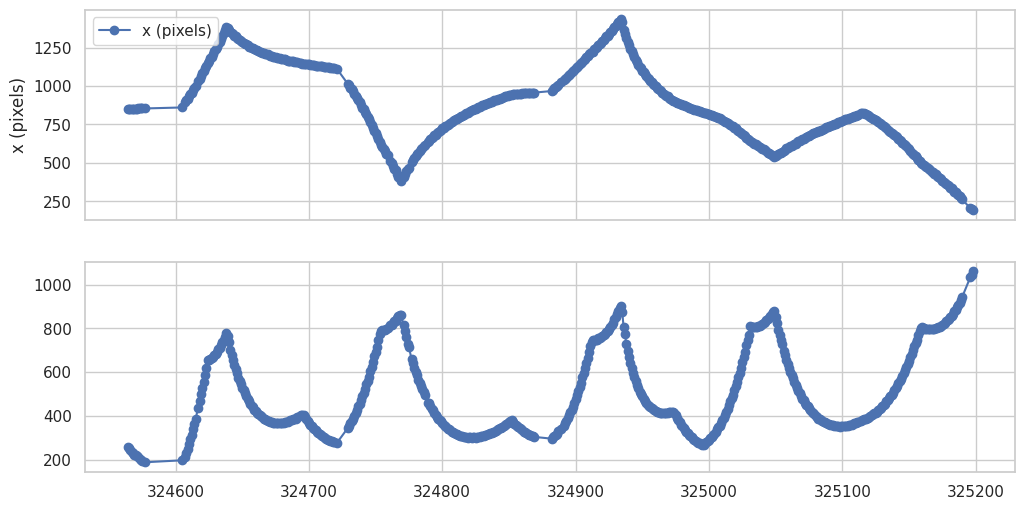

In [136]:
plot_ball_timeseries(115,full_df['delta_speed']*10)

/tmp/ipykernel_28570/4016821807.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
/tmp/ipykernel_28570/4016821807.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Action')


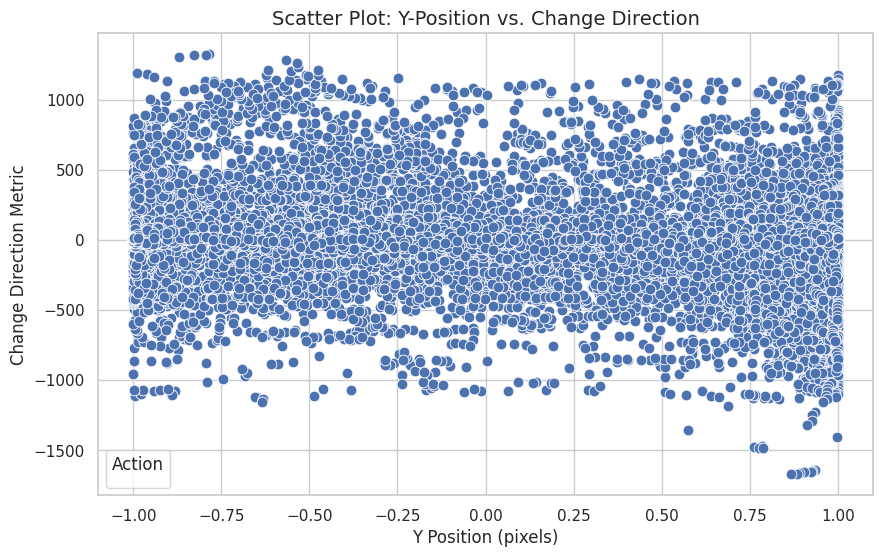

In [167]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the visual style
sns.set_theme(style="whitegrid")

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=X_features, 
    x='cosine_sim', 
    y='delta_speed', 
    #hue='action',    # Colors points based on 'action' (air, hit, bounce)
    #style='action',  # Changes point shape based on 'action'
    palette='deep',  # Color palette
    s=60             # Size of points
)

# Add titles and labels
plt.title('Scatter Plot: Y-Position vs. Change Direction', fontsize=14)
plt.xlabel('Y Position (pixels)', fontsize=12)
plt.ylabel('Change Direction Metric', fontsize=12)
plt.legend(title='Action')

# Show the plot
plt.show()

In [2]:
df=pd.read_json("data/ball_data_115.json")
df=df.T
#let's not consider the frames where the ball is not detected (not visible)
print("Initial number of frames:",df.shape)
df=df[df['visible']==1]
print("Number of frames with ball visible:",df.shape)

Initial number of frames: (685, 4)
Number of frames with ball visible: (572, 4)


In [49]:
df['smooth_y'] = df['y'].rolling(window=5, center=True).mean()
df['vy'] = df['smooth_y'].diff()
df['ay'] = df['vy'].diff()

In [50]:
window=3

In [51]:
# Compute average velocity BEFORE the candidate frame (idx)
before_vy = df['vy'].shift(1).rolling(window=window).mean().fillna(method='bfill')
after_vy = df['vy'].iloc[::-1].rolling(window=window).mean().fillna(method='bfill').iloc[::-1]

/tmp/ipykernel_200789/1265760981.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  before_vy = df['vy'].shift(1).rolling(window=window).mean().fillna(method='bfill')
/tmp/ipykernel_200789/1265760981.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  after_vy = df['vy'].iloc[::-1].rolling(window=window).mean().fillna(method='bfill').iloc[::-1]


In [52]:
test=np.sign(before_vy.fillna(0))*np.sign(after_vy.fillna(0))
test.unique()

array([-0.,  1., -1.])

In [62]:
before_diff=df['y'].shift(window)-df['y']
after_diff=df['y']-df['y'].shift(-window)
df['change_direction'] = (before_diff-after_diff).fillna(0)

/tmp/ipykernel_200789/1477857263.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['change_direction'] = (before_diff-after_diff).fillna(0)


In [63]:
df

,x,y,visible,action,smooth_y,vy,ay,change_direction
110577,837,670,True,air,NaN,NaN,NaN,0.0
110578,837,656,True,air,NaN,NaN,NaN,0.0
110579,835,642,True,air,643.8,NaN,NaN,0.0
110580,835,632,True,air,631.4,-12.4,NaN,3.0
110581,835,619,True,air,619.6,-11.8,0.6,4.0
...,...,...,...,...,...,...,...,...
110874,1312,632,True,air,633.0,2.2,1.6,-2.0
110875,1314,635,True,air,634.4,1.4,-0.8,-5.0
110876,1316,637,True,air,635.2,0.8,-0.6,0.0
110878,1317,636,True,air,NaN,NaN,NaN,0.0


In [64]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns

df_model=df[['x','y','change_direction']].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model)

# Fit K-Means
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_model['cluster'] = kmeans.fit_predict(X_scaled)


In [65]:
action_df = df[['action']]
merge_df = action_df.merge(df_model[['cluster']], left_index=True, right_index=True)

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create the contingency table
# Rows = Actual Actions (Ground Truth)
# Columns = Predicted Clusters (0, 1, 2)
crosstab = pd.crosstab(merge_df['action'], merge_df['cluster'])

print("--- Confusion Matrix (Counts) ---")
print(crosstab)

--- Confusion Matrix (Counts) ---
cluster    0    1  2
action              
air      113  152  9
bounce     0    0  1
hit        0    1  2


In [68]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# 1. Select features
# Use a mix of position derivatives and stats

# 2. Prepare data (Drop NaNs)
df_ml = df[['x','y','change_direction']].copy()

# 3. Standardize (Crucial for Isolation Forest)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_ml)

# 4. Fit Isolation Forest
# contamination=0.01 means "I expect about 1% of my data to be anomalies"
iso = IsolationForest(contamination=0.01, random_state=42)
df_ml['anomaly_score'] = iso.fit_predict(X_scaled)

# Map back (-1 = Anomaly, 1 = Normal)
df.loc[df_ml.index, 'is_anomaly_if'] = df_ml['anomaly_score'] == -1

# Inspect
print(f"Found {df['is_anomaly_if'].sum()} ML anomalies.")

Found 3 ML anomalies.


In [69]:
anomalies = df[df['is_anomaly_if']]
anomalies

,x,y,visible,action,smooth_y,vy,ay,change_direction,is_anomaly_if
110718,754,650,True,air,642.228713,12.2,-5.228713,-68.000000,True
110719,739.450495,665.143564,True,hit,647.428713,5.2,-7.000000,-94.287129,True
110721,763,653,True,air,646.028713,-1.4,-6.600000,-65.000000,True


In [57]:
import json
def plot_ball_timeseries(point_ID,test):

    with open(f'data/ball_data_{point_ID}.json', 'r') as file:
        ball_data = json.load(file)
    ball_data = {int(frame): data for frame, data in ball_data.items()}

    bounces_data = {}
    hits_data = {}

    # ---- Iterate through all frames ----
    for frame_str, info in ball_data.items():
        action = info.get("action", None)
        frame = int(frame_str)

        if action == "bounce":
            bounces_data[frame] = info

        elif action == "hit":
            hits_data[frame] = info


    dico_ball = ball_data
    hits = hits_data
    bounces = bounces_data
    # 1) Sort frames and build arrays
    frames = sorted(dico_ball.keys())

    frames_visible = []
    x_vals = []
    y_vals = []

    for f in frames:
        d = dico_ball[f]
        # keep only visible points with valid x,y
        if d.get("visible") and d.get("x") is not None and d.get("y") is not None:
            frames_visible.append(f)
            x_vals.append(d["x"])
            y_vals.append(d["y"])

    frames_visible = np.array(frames_visible)
    x_vals = np.array(x_vals, dtype=float)
    y_vals = np.array(y_vals, dtype=float)

    # 2) Create figure with 2 subplots: x vs frame, y vs frame
    fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    ax_x, ax_y = axes

    # Plot x
    #ax_x.plot(frames_visible, x_vals, marker='o', linestyle='-', label='x (pixels)')
    ax_x.plot(frames_visible, test, marker='o', linestyle='-', label='y (pixels)')

    ax_x.set_ylabel("x (pixels)")
    ax_x.legend(loc="upper left")

    # Plot y
    ax_y.plot(frames_visible, y_vals, marker='o', linestyle='-', label='y (pixels)')
    ax_y.set_ylabel("y (pixels)")
    ax_y.set_xlabel("Frame")
    ax_y.legend(loc="upper left")

    # 3) Add vertical lines for hits (green) and bounces (red)
    hits = sorted(hits)
    bounces = sorted(bounces)

    for h in hits:
        ax_x.axvline(h, color='g', linestyle='--', alpha=0.7, label='Hit')
        ax_y.axvline(h, color='g', linestyle='--', alpha=0.7, label='Hit')

    for b in bounces:
        ax_x.axvline(b, color='r', linestyle='--', alpha=0.7,  label='Bounce')
        ax_y.axvline(b, color='r', linestyle='--', alpha=0.7,label='Bounce')

    # Optional: x-limits around data & events
    all_frames_for_limits = frames_visible.tolist() + hits + bounces
    if all_frames_for_limits:
        x_min = min(all_frames_for_limits) - 5
        x_max = max(all_frames_for_limits) + 5
        ax_x.set_xlim(x_min, x_max)

    plt.tight_layout()
    plt.legend()
    plt.show()

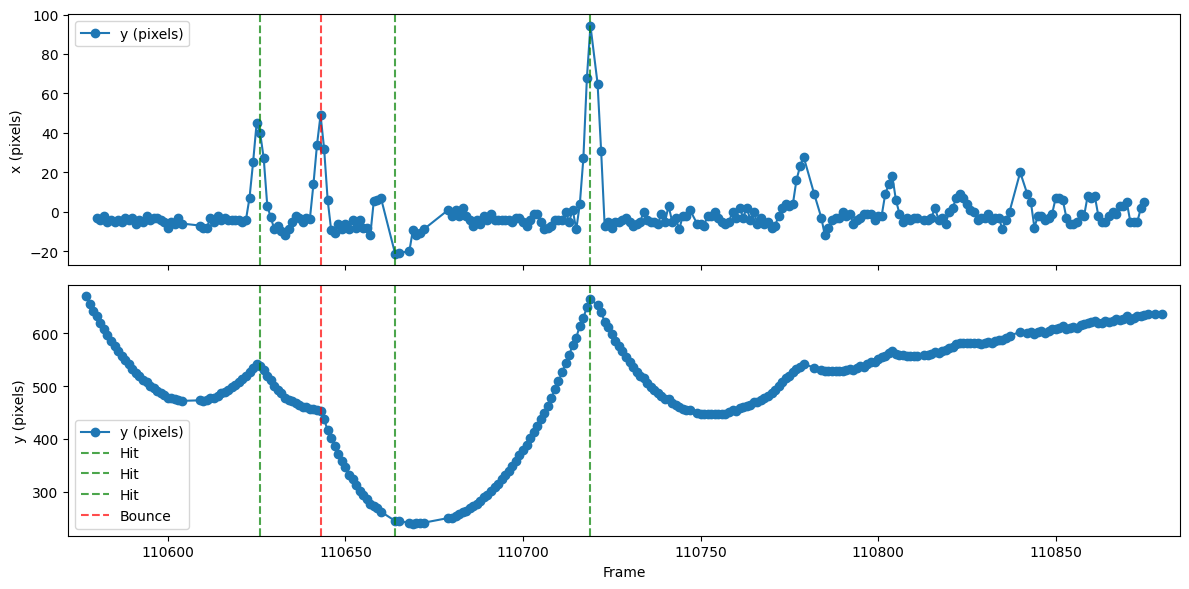

In [61]:
plot_ball_timeseries(33,after_diff-before_diff)

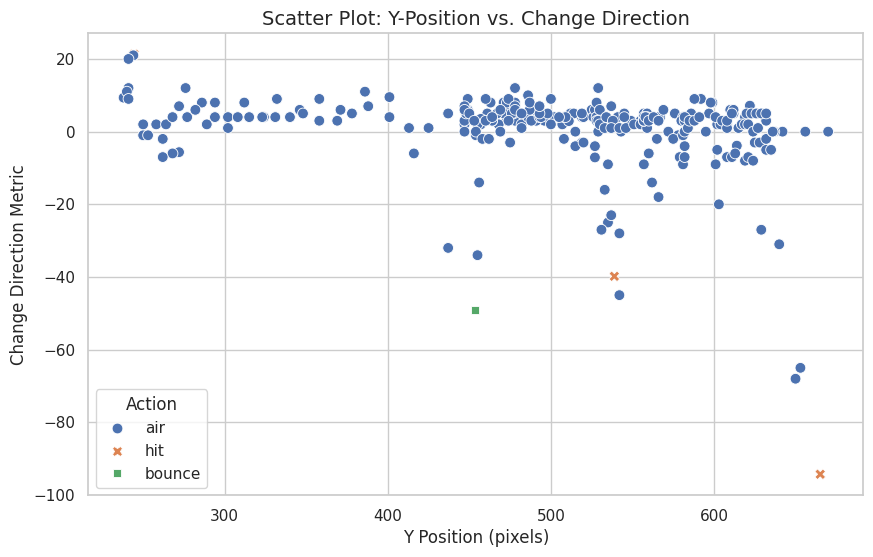

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the visual style
sns.set_theme(style="whitegrid")

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df, 
    x='y', 
    y='change_direction', 
    hue='action',    # Colors points based on 'action' (air, hit, bounce)
    style='action',  # Changes point shape based on 'action'
    palette='deep',  # Color palette
    s=60             # Size of points
)

# Add titles and labels
plt.title('Scatter Plot: Y-Position vs. Change Direction', fontsize=14)
plt.xlabel('Y Position (pixels)', fontsize=12)
plt.ylabel('Change Direction Metric', fontsize=12)
plt.legend(title='Action')

# Show the plot
plt.show()

In [71]:
# --- CELL 1: Imports ---
import pandas as pd
import numpy as np
import stumpy
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Set a visual style for plots
sns.set_theme(style="whitegrid")

In [82]:
df=pd.read_json("data/ball_data_33.json")
df=df.T
#let's not consider the frames where the ball is not detected (not visible)
print("Initial number of frames:",df.shape)
df=df[df['visible']==1]
print("Number of frames with ball visible:",df.shape)

Initial number of frames: (337, 4)
Number of frames with ball visible: (278, 4)


In [101]:
import glob
import json
import pandas as pd
import numpy as np
from tqdm import tqdm

# 1. Define your folder path (Change 'data_folder' to your actual path)
folder_path = "data/*.json" 
file_list = glob.glob(folder_path)

frames_list = []
m = 15  # Window size (needed for the spacer)

print(f"Found {len(file_list)} files. Starting concatenation...")

# 2. Loop through every file in the folder
for filepath in tqdm(file_list):
    # B. Convert to DataFrame
    df_temp = pd.read_json(filepath)
    df_temp = df_temp.T  # Transpose if necessary
    df_temp=df_temp[df_temp['visible']==1]
    df_temp=df_temp.drop(columns=['visible'])
    
    df_temp['filename'] = filepath
    
    # E. Add to list
    frames_list.append(df_temp)
    
    # F. Insert "Spacer" (NaNs) between files
    # This prevents the algorithm from analyzing a pattern that crosses two different matches
    spacer = pd.DataFrame(index=range(m), columns=df_temp.columns)
    spacer['y'] = np.nan       # Stumpy ignores windows with NaNs
    spacer['filename'] = 'SPACER'
    frames_list.append(spacer)

# 3. Concatenate all files into one distinct DataFrame
full_df = pd.concat(frames_list).reset_index(drop=True)

print(f"Successfully created 'full_df' with shape: {full_df.shape}")

Found 313 files. Starting concatenation...


100%|██████████| 313/313 [00:22<00:00, 13.68it/s]

Successfully created 'full_df' with shape: (118368, 4)


In [102]:
before_diff=df['y'].shift(window)-df['y']
after_diff=df['y']-df['y'].shift(-window)
df['change_direction'] = (before_diff-after_diff).fillna(0)

/tmp/ipykernel_200789/1477857263.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['change_direction'] = (before_diff-after_diff).fillna(0)


Computing Matrix Profile (this may take a moment)...


/home/ysidhom/Documents/M2DS/QSA_tennis/.venv/lib/python3.12/site-packages/stumpy/core.py:2257: RuntimeWarning: divide by zero encountered in divide
  Σ_T_inverse = 1.0 / Σ_T


Anomaly Threshold: 0.3822
Processing 29589 raw candidates...
Final valid shapes for clustering: 2825


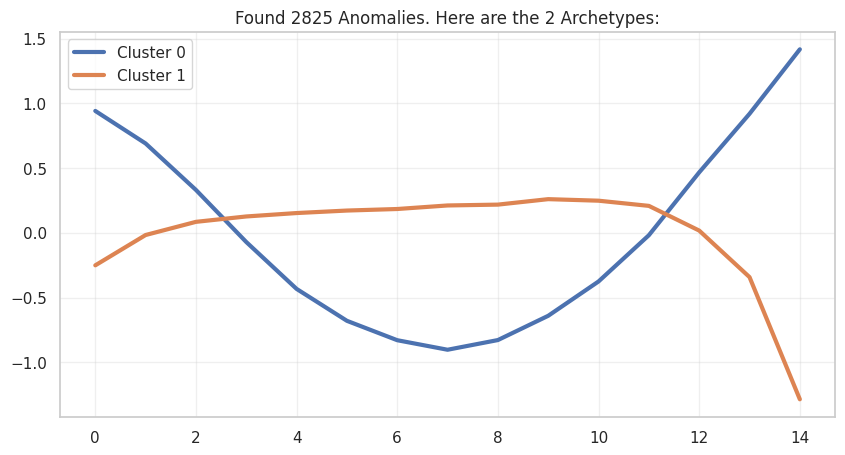

Success! Now check the graph above to set your 'cluster_map'.


In [112]:
# --- MERGED CELLS 3, 4, & 5: Detect, Extract, and Cluster ---
from sklearn.cluster import KMeans
import stumpy

# 1. Re-Verify Data Exists
if 'full_df' not in locals():
    raise ValueError("full_df is missing! Please run the 'Load & Concatenate' cell (Cell 1) first.")

m = 15  # Window size

# 2. Compute Matrix Profile (The "Anomaly Detector")
print("Computing Matrix Profile (this may take a moment)...")
data = full_df['y'].values.astype(float)
mp = stumpy.stump(data, m=m)

# 3. Save Scores to DataFrame (Handling Padding)
profile_distance = mp[:, 0]
padding_len = len(full_df) - len(profile_distance)
padding = np.full(padding_len, np.nan)
full_df['anomaly_score'] = np.concatenate([profile_distance, padding])

# 4. Identify Candidates (Top 5% Outliers)
# Filter out NaNs (spacers) first
valid_scores = full_df['anomaly_score'].dropna()
if len(valid_scores) == 0:
    raise ValueError("Error: Anomaly scores are all NaN. Check your input data.")

threshold = np.percentile(valid_scores, 75)
print(f"Anomaly Threshold: {threshold:.4f}")

# Find indices in the full dataframe
candidate_indices = full_df[full_df['anomaly_score'] > threshold].index.values

# 5. Extract Shapes (Debouncing & Logic Check)
shapes = []
clean_indices = []

# Sort by highest score first
candidate_scores = full_df.loc[candidate_indices, 'anomaly_score'].values
sorted_indices = candidate_indices[np.argsort(candidate_scores)[::-1]]

print(f"Processing {len(sorted_indices)} raw candidates...")

for idx in sorted_indices:
    # A. Debounce: Ensure this candidate is far from already selected ones
    if all(abs(idx - existing) > m for existing in clean_indices):
        
        # B. Check Validity: Must not be a Spacer
        # (We check the window in the dataframe to ensure it belongs to ONE file)
        window_data = full_df.iloc[idx : idx+m]
        
        # Only keep if window is fully inside ONE file (not crossing files)
        if window_data['filename'].nunique() == 1 and window_data['filename'].iloc[0] != 'SPACER':
            
            # C. Extract the Shape
            seq = data[idx : idx+m]
            
            # Normalize (Z-score normalization)
            # This ensures we cluster based on SHAPE, not absolute Y position
            seq_norm = (seq - seq.mean()) / (seq.std() + 1e-6)
            
            shapes.append(seq_norm)
            clean_indices.append(idx)

X_shapes = np.array(shapes)

# 6. Safety Check & Clustering
print(f"Final valid shapes for clustering: {len(X_shapes)}")

if len(X_shapes) == 0:
    print("WARNING: No valid shapes found. Lower your threshold or check 'full_df['y']' for data.")
else:
    # Run K-Means
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_shapes)

    # Visualize
    centroids = kmeans.cluster_centers_
    plt.figure(figsize=(10, 5))
    plt.plot(centroids[0], label='Cluster 0', linewidth=3)
    plt.plot(centroids[1], label='Cluster 1', linewidth=3)
    plt.title(f"Found {len(X_shapes)} Anomalies. Here are the 2 Archetypes:")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    print("Success! Now check the graph above to set your 'cluster_map'.")

In [115]:
# --- CELL 6: Assign Labels to the Giant DataFrame ---

# !!!!!!!!!!!!!!!! MANUAL CHECK !!!!!!!!!!!!!!!!
# Look at the "Archetypes" plot you generated in the previous cell.
# - If Cluster 0 is the "V-shape" (Bounce), map 0 -> 'bounce'.
# - If Cluster 0 is the "Sharp Reversal" (Hit), map 0 -> 'hit'.
cluster_map = {
    0: 'bounce',  # <--- UPDATE THIS based on your plot
    1: 'hit'      # <--- UPDATE THIS based on your plot
}
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# 1. Initialize prediction column with 'air' (default)
full_df['pred_action'] = 'air'

# 2. Offset calculation
# The anomaly was detected at the START of the window (idx). 
# The actual event happens in the MIDDLE of the window.
offset = m // 2

# 3. Assign labels
# We iterate through 'clean_indices' (the valid start positions we found earlier)
for i, start_idx in enumerate(clean_indices):
    
    # Calculate the exact row index in the giant DataFrame
    center_idx = start_idx + offset
    
    # Get the cluster ID (0 or 1) assigned by K-Means
    cluster_id = labels[i]
    
    # Map to 'hit' or 'bounce'
    action_label = cluster_map[cluster_id]
    
    # Update the dataframe
    # We use .at[] for fast scalar access
    if center_idx < len(full_df):
        full_df.at[center_idx, 'pred_action'] = action_label

print("Classification complete.")
print("\nGlobal Event Counts:")
print(full_df['pred_action'].value_counts())

# --- OPTIONAL: Sanity Check on One File ---
# Let's peek at the first file to see if the labels look reasonable
first_file = full_df['filename'].unique()[0]
subset = full_df[full_df['filename'] == first_file]

print(f"\nSample results for file: {first_file}")
print(subset[['y', 'anomaly_score', 'pred_action','action']].head(20))

Classification complete.

Global Event Counts:
pred_action
air       115543
bounce      1736
hit         1089
Name: count, dtype: int64

Sample results for file: data/ball_data_115.json
             y anomaly_score pred_action action
0          257      0.327569         air    air
1          251      0.412601         air    air
2          243      0.432414         air    air
3          236      0.400171         air    air
4          230      0.379426         air    air
5          223      0.309302         air    air
6          220      0.188017         air    air
7          218        0.1725         air    air
8          211      0.152102         air    air
9          203      0.232258      bounce    air
10         198      0.207757         air    air
11         193      0.125187         air    air
12         188      0.096479         air    air
13  196.947917      0.064518         air    hit
14         212      0.069177         air    air
15         232       0.07448         air    ai

In [116]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create the contingency table
# Rows = Actual Actions (Ground Truth)
# Columns = Predicted Clusters (0, 1, 2)
crosstab = pd.crosstab(full_df['action'], full_df['pred_action'])

print("--- Confusion Matrix (Counts) ---")
print(crosstab)

--- Confusion Matrix (Counts) ---
pred_action     air  bounce   hit
action                           
air          107905    1657  1065
bounce         1427       2    17
hit            1516      77     7
